## 1 Import dependencies

In [1]:
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys,os
sys.path.append("..")
from utils import *

## 2 Keypoints using mp holistic

In [2]:
cap = cv2.VideoCapture(0)


with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame,holistic)
        # image, results = draw_landmarks(frame,holistic)
        # print(results.left_hand_landmarks)

        cv2.imshow("frame",frame)

        if cv2.waitKey(10) & 0xFF==ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/rhythm/.local/lib/python3.10/site-packages/cv2/qt/plugins"


Note-: Landmark values -> The face and hand landmarks models will return no values if nothing is detected.
The pose model will return landmarks but the visibility value inside of each landmark will be low  

In [3]:
draw_landmarks(frame,results)

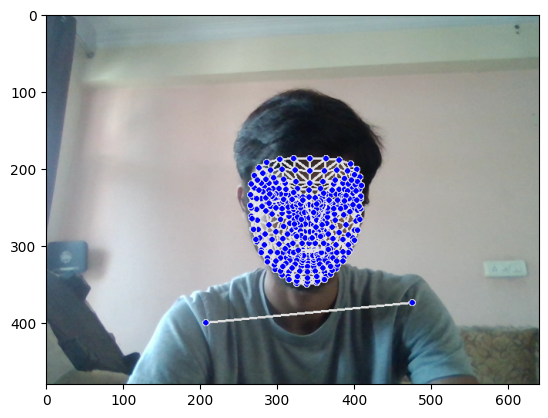

In [4]:
img = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
draw_landmarks(img,results)
plt.imshow(img)

### 2.1 Capturing body landmarks

In [5]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret,frame = cap.read()

        # Make detections
        image,results = mediapipe_detection(frame,holistic)

        # Draw landmarks
        draw_styled_landmarks(image,results)
        # print(results.left_hand_landmarks)
        # print(results.right_hand_landmarks)

        # Show to screen
        cv2.imshow("Opencv feed",image)

        if cv2.waitKey(10) & 0xFF==ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

## 3 Extract keypoint values

### 3.1 Storing all the pose_landmarks, left_hand_landmarks, right_hand_landmarks in separate (flattened) array 

In [6]:
def extract_keypoints(results):
    # If the respective posture was captured in the last frame then it will output the landmark values otherwise zero array of same shape
    lefthand = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    righthand = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten()  if results.right_hand_landmarks else np.zeros(21*3)
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return np.concatenate([pose,face,lefthand,righthand])

In [7]:
arr = extract_keypoints(results)

## 4 Setup folders for collection

Note -: In action detection, a sequence of data is used rather than a single frame

In [8]:
# Path for exported data (numpy arrays)
DATA_PATH = os.path.join('MP_DATA')

# Actions that we try to detect
actions = np.array(["hello","thanks","iloveyou"])

# 30 videos worth of data
num_sequences = 30

# Each video is going to be 30 frames in length
sequence_length = 30

* The data will consist of 30 videos per action.
* Then each video sequence is going to contain 30 frames of data.
* Each framework will contain 1662 landmark values i.e. 3*30 sequences,30 frames,1662 landmarks

In [9]:
# hello
# thanks
# i love you

In [17]:
for action in actions:
    for sequence in range(num_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)),exist_ok=True)
        except Exception as e:
            print(e)

## 5 Collect keypoint values for training and testing 

In [18]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_tracking_confidence=0.5,min_detection_confidence=0.5) as holistic:

    # Loop through actions
    for action in actions:
        # Loop through sequences i.e. videos
        for sequence in range(num_sequences):
            # Loop through video length i.e. video length
            for frame_num in range(sequence_length):
                # Read frame
                ret, frame = cap.read()

                # Make detections
                image,results = mediapipe_detection(frame,holistic)

                # Draw landmarks
                draw_styled_landmarks(image,results)

                # Collection breaks
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                 # Show to screen
                cv2.imshow("Opencv feed",image)
                
                # Export keypoints
                keypoints=extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH,action,str(sequence),str(frame_num))
                np.save(npy_path,keypoints)

               

                if cv2.waitKey(10) & 0xFF==ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

## 6 Preprocess data and create labels and features

In [24]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [26]:
# labelling the actions
label_map = {label:num for num,label in enumerate(actions)}

In [28]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [52]:
sequences,labels=[],[]
for action in actions:
    for sequence in range(num_sequences):
        window = []
        for frame_num in range(sequence_length):
            res=np.load(os.path.join(DATA_PATH,action,str(sequence),f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [58]:
print(np.array(sequences).shape)
print(np.array(labels).shape)

(90, 30, 1662)
(90,)


In [60]:
X = np.array(sequences)
X.shape

(90, 30, 1662)

In [66]:
y=to_categorical(labels).astype(int)
y.shape

(90, 3)

In [68]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.05)

## 7 Build and Train LSTM Neural Network